# Analog bit project walkthrough

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
try:
    from tueplots import bundles
    plt.rcParams.update(bundles.neurips2022())
except ModuleNotFoundError:
    pass
%load_ext autoreload
%autoreload 2

## How to generate the data

Several ways to create data, only one generator is implemented, the ```flags``` dataset

In [28]:
# imports
from utils.data_gen import get_data_gen

In [30]:
generate_data = get_data_gen('flags', (3,8), 10, rgb=True)

In [25]:
data = generate_data()

In [26]:
data.shape

(10, 3, 8, 3)

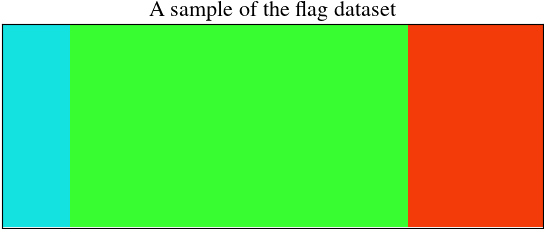

In [31]:
from matplotlib import ticker

plt.imshow(data[5])
plt.title('A sample of the flag dataset', fontsize=16)
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.NullLocator())
_ = ax.yaxis.set_major_locator(ticker.NullLocator())

## Convert to bits

In [32]:
from utils.bit_encoding import rgb2bit, get_x_channels

b_type = 'uint8'
channels = get_x_channels(b_type)
dataset_bits = rgb2bit(images=data, b_type=b_type, b_scale=1.0, x_channels=channels)

2023-05-12 15:45:25.510257: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [38]:
print("(Number of samples, height, width, analogbits) =", dataset_bits.shape)

(Number of samples, height, width, analogbits) = (10, 3, 8, 24)


## Define noise and denoiser step

In [39]:
from utils.diffusion_utils import noise

In [ ]:
def train_loss(x):
    """Return the loss value for an input batch"""
    x_bits = rgb2bit(x, b_type=b_type, b_scale=1.0, x_channels=channels)
    ndim = x_bits[0,:].ravel.shape[0]
    t = np.random.uniform(size=[x_bits.shape[0] + [1]*(ndim-1)])
    x_crypt = noise()